In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest,  f_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

df = pd.read_csv('../datasets/anxiety_depression_data.csv')
print("First few rows of the dataset:")
print(df.head())

print(f"Dataset shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum()}")

First few rows of the dataset:
   Age  Gender Education_Level Employment_Status  Sleep_Hours  \
0   56    Male      Bachelor's        Unemployed          6.0   
1   69  Female      Bachelor's           Retired          8.8   
2   46  Female        Master's          Employed          5.3   
3   32  Female     High School        Unemployed          8.8   
4   60  Female      Bachelor's           Retired          7.2   

   Physical_Activity_Hrs  Social_Support_Score  Anxiety_Score  \
0                    0.4                     3              4   
1                    2.8                     6             18   
2                    1.6                     5              5   
3                    0.5                     4              6   
4                    0.7                     2              7   

   Depression_Score  Stress_Level  Family_History_Mental_Illness  \
0                 2             9                              0   
1                 7             6                  

In [139]:
# 2. Data Preprocessing - One-Hot Encoding
categorical_columns = ['Gender', 'Education_Level', 'Employment_Status', 'Meditation']
X = df.copy()
X_encoded = pd.get_dummies(X, columns=categorical_columns, prefix=categorical_columns)
X = X_encoded

# Define target variable (only depression)
y = df['Depression_Score']

# Remove target variables from features
X = X.drop(['Depression_Score'], axis=1)

print("Shape after encoding:", X.shape)
print("\nFeature names:")
print(X.columns.tolist())

Shape after encoding: (1200, 28)

Feature names:
['Age', 'Sleep_Hours', 'Physical_Activity_Hrs', 'Social_Support_Score', 'Anxiety_Score', 'Stress_Level', 'Family_History_Mental_Illness', 'Chronic_Illnesses', 'Therapy', 'Financial_Stress', 'Work_Stress', 'Self_Esteem_Score', 'Life_Satisfaction_Score', 'Loneliness_Score', 'Gender_Female', 'Gender_Male', 'Gender_Non-Binary', 'Gender_Other', "Education_Level_Bachelor's", 'Education_Level_High School', "Education_Level_Master's", 'Education_Level_Other', 'Education_Level_PhD', 'Employment_Status_Employed', 'Employment_Status_Retired', 'Employment_Status_Student', 'Employment_Status_Unemployed', 'Meditation_Meditation']


In [140]:
# New Cell: Feature Engineering
# Create interaction features
X['Stress_Financial_Interaction'] = X['Stress_Level'] * X['Financial_Stress']
X['Support_Loneliness_Interaction'] = X['Social_Support_Score'] * X['Loneliness_Score']
X['Sleep_Activity_Interaction'] = X['Sleep_Hours'] * X['Physical_Activity_Hrs']

# Print new feature names
print("New features added:")
print(X.columns.tolist())

New features added:
['Age', 'Sleep_Hours', 'Physical_Activity_Hrs', 'Social_Support_Score', 'Anxiety_Score', 'Stress_Level', 'Family_History_Mental_Illness', 'Chronic_Illnesses', 'Therapy', 'Financial_Stress', 'Work_Stress', 'Self_Esteem_Score', 'Life_Satisfaction_Score', 'Loneliness_Score', 'Gender_Female', 'Gender_Male', 'Gender_Non-Binary', 'Gender_Other', "Education_Level_Bachelor's", 'Education_Level_High School', "Education_Level_Master's", 'Education_Level_Other', 'Education_Level_PhD', 'Employment_Status_Employed', 'Employment_Status_Retired', 'Employment_Status_Student', 'Employment_Status_Unemployed', 'Meditation_Meditation', 'Stress_Financial_Interaction', 'Support_Loneliness_Interaction', 'Sleep_Activity_Interaction']


In [141]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (960, 31), Test set: (240, 31)


In [142]:
# 4. Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training data after scaling:")
print(f"Mean: {X_train_scaled.mean(axis=0).round(10)}")
print(f"Std: {X_train_scaled.std(axis=0)}")

Training data after scaling:
Mean: [-0.  0. -0. -0.  0. -0.  0. -0. -0.  0. -0.  0.  0. -0.  0. -0.  0.  0.
  0.  0.  0.  0. -0.  0.  0.  0. -0.  0. -0. -0. -0.]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1.]


In [143]:
# Cell 5: Feature Selection using SelectKBest for Depression only

# Convert continuous target to binary class for depression only
depression_threshold = 15  # Using the same threshold as before
y_train_class = (y_train > depression_threshold).astype(int)
y_test_class = (y_test > depression_threshold).astype(int)

# Select top 10 features for depression
k_best_depression = SelectKBest(score_func=f_classif, k=10)

# Fit and transform for depression only
X_train_selected = k_best_depression.fit_transform(X_train_scaled, y_train_class)
X_test_selected = k_best_depression.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train.columns[k_best_depression.get_support()].tolist()

print("Depression classification threshold:", depression_threshold)
print("\nDepression class distribution:")
print(pd.Series(y_train_class).value_counts())
print("\nSelected features for Depression:")
print(selected_features)

Depression classification threshold: 15

Depression class distribution:
Depression_Score
0    714
1    246
Name: count, dtype: int64

Selected features for Depression:
['Age', 'Stress_Level', 'Family_History_Mental_Illness', 'Chronic_Illnesses', 'Work_Stress', 'Gender_Female', "Education_Level_Master's", 'Employment_Status_Retired', 'Stress_Financial_Interaction', 'Sleep_Activity_Interaction']


c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


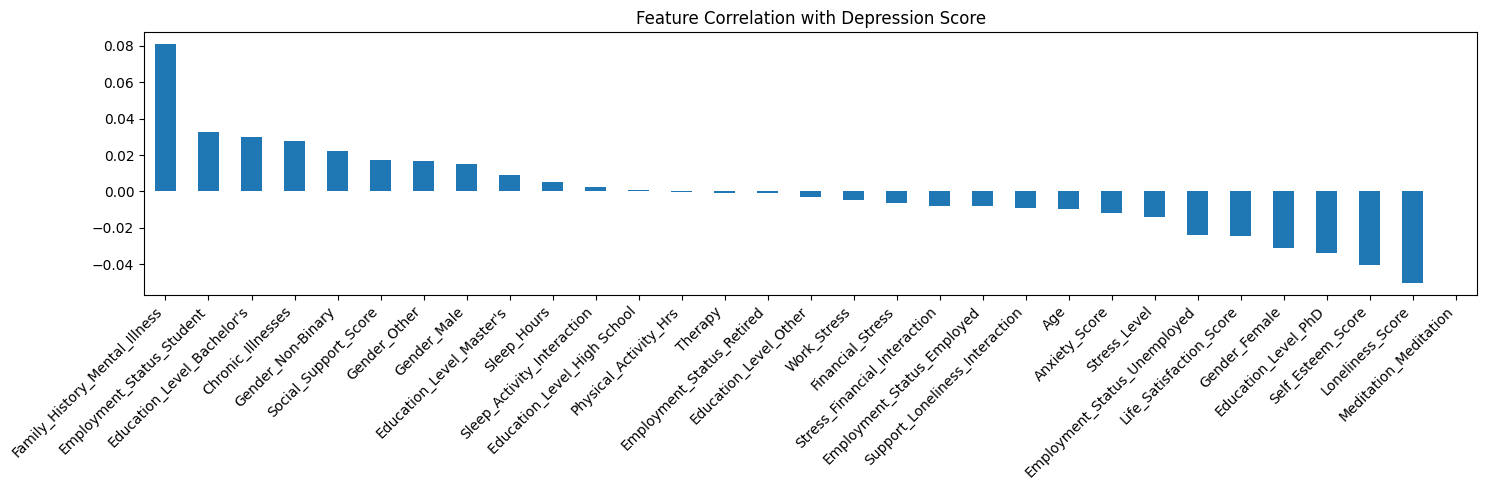

Top 5 features correlated with Depression Score:
Family_History_Mental_Illness    0.080849
Employment_Status_Student        0.032463
Education_Level_Bachelor's       0.030053
Chronic_Illnesses                0.027615
Gender_Non-Binary                0.022097
dtype: float64


In [144]:
# 6. Correlation Analysis
plt.figure(figsize=(15, 5))

# Depression Score Correlation
correlation_matrix_dep = X.corrwith(y).sort_values(ascending=False)
plt.subplot(1, 1, 1)
correlation_matrix_dep.plot(kind='bar')
plt.title('Feature Correlation with Depression Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print top 5 correlated features
print("Top 5 features correlated with Depression Score:")
print(correlation_matrix_dep.head(5))

In [145]:
# 7. Support Vector Machine Classification
# Train SVM for Depression
svm_depression = SVC(kernel='rbf', probability=True, random_state=42)
svm_depression.fit(X_train_selected, y_train_class)

# Make predictions
svm_pred = svm_depression.predict(X_test_selected)

# Print results
print("SVM Classification Results:")
print(f"Accuracy: {accuracy_score(y_test_class, svm_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, svm_pred))

SVM Classification Results:
Accuracy: 0.8042

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       193
           1       0.00      0.00      0.00        47

    accuracy                           0.80       240
   macro avg       0.40      0.50      0.45       240
weighted avg       0.65      0.80      0.72       240



c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [146]:
# 8. Random Forest Classification
# Train Random Forest for Depression
rf_depression = RandomForestClassifier(n_estimators=100, random_state=42)
rf_depression.fit(X_train_selected, y_train_class)

# Make predictions
rf_pred = rf_depression.predict(X_test_selected)

# Print results
print("Random Forest Classification Results:")
print(f"Accuracy: {accuracy_score(y_test_class, rf_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, rf_pred))

Random Forest Classification Results:
Accuracy: 0.7875

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       193
           1       0.17      0.02      0.04        47

    accuracy                           0.79       240
   macro avg       0.49      0.50      0.46       240
weighted avg       0.68      0.79      0.72       240



In [147]:
# Cell 10: Model Evaluation
# Compare both models
print("Model Comparison:")
print("\nSVM Model:")
print(f"Accuracy: {accuracy_score(y_test_class, svm_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, svm_pred))

print("\nRandom Forest Model:")
print(f"Accuracy: {accuracy_score(y_test_class, rf_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, rf_pred))

Model Comparison:

SVM Model:
Accuracy: 0.8042

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       193
           1       0.00      0.00      0.00        47

    accuracy                           0.80       240
   macro avg       0.40      0.50      0.45       240
weighted avg       0.65      0.80      0.72       240


Random Forest Model:
Accuracy: 0.7875

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       193
           1       0.17      0.02      0.04        47

    accuracy                           0.79       240
   macro avg       0.49      0.50      0.46       240
weighted avg       0.68      0.79      0.72       240



c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chetak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

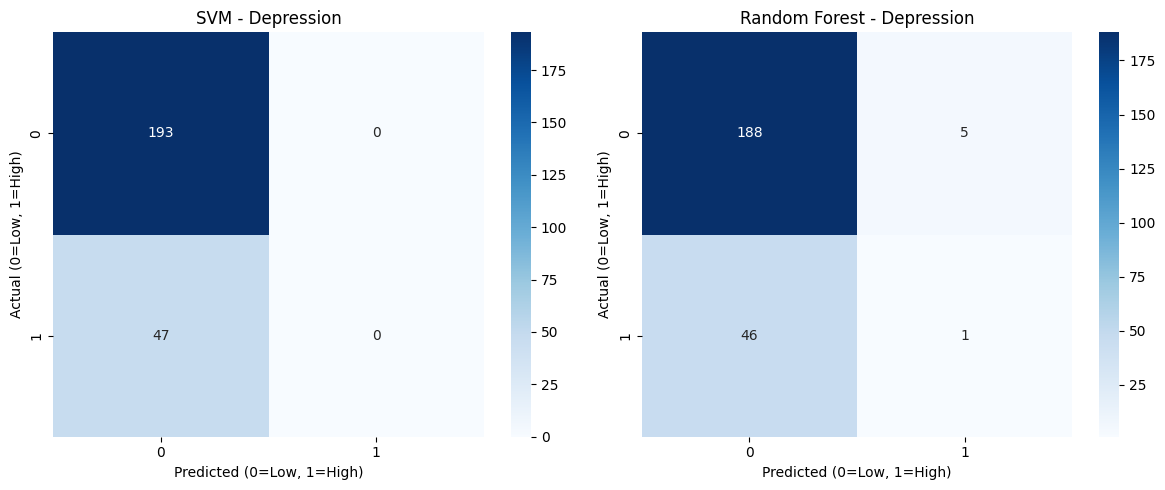

In [148]:
# Cell 11: Confusion Matrices
plt.figure(figsize=(12, 5))

# Create confusion matrices
svm_cm = confusion_matrix(y_test_class, svm_pred)
rf_cm = confusion_matrix(y_test_class, rf_pred)

# Plot confusion matrices
plt.subplot(1, 2, 1)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM - Depression')
plt.xlabel('Predicted (0=Low, 1=High)')
plt.ylabel('Actual (0=Low, 1=High)')

plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Depression')
plt.xlabel('Predicted (0=Low, 1=High)')
plt.ylabel('Actual (0=Low, 1=High)')

plt.tight_layout()
plt.show()